# Forecasting fire probability and sizes with SMLFire1.0

Author: Jatan Buch (v1, 230724)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Fire probability/frequency forecasts

### Loading observed and forecast climate predictors

In [ ]:
# load in data frame with observed climate, vegetation, and human predictors

clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_data.h5') 
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

In [ ]:
pred_var_arr= ['Tmax', 'Prec',  'VPD', 'FFWI', 'Tmin'] 
run_id_arr= ['grid_normalized_lead1mo', 'grid_normalized_lead2mo', 'grid_normalized_lead3mo']
mb_frac= '0.1'
pred_mon_arr= [461, 462, 463]
pred_tot_loc_df= pd.DataFrame([])
pred_tot_scale_df= pd.DataFrame([])

for pred_var in tqdm(pred_var_arr):
    mon_ind= 0
    pred_var_loc_df= pd.DataFrame([])
    pred_var_scale_df= pd.DataFrame([])
    for run_id in run_id_arr:
        pred_loc_xarr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
        pred_scale_xarr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
        pred_var_loc_df= pd.concat([pred_var_loc_df, pred_loc_xarr[-4+mon_ind, :, :].to_dataframe(pred_var).reset_index()], ignore_index= True)
        pred_var_scale_df= pd.concat([pred_var_scale_df, pred_scale_xarr[-4+mon_ind, :, :].to_dataframe(pred_var).reset_index()], ignore_index= True)
        mon_ind+= 1
    
    pred_tot_loc_df= pd.concat([pred_tot_loc_df, pred_var_loc_df], axis= 1).drop(columns= ['X', 'Y'])
    pred_tot_scale_df= pd.concat([pred_tot_scale_df, pred_var_scale_df], axis= 1).drop(columns= ['X', 'Y'])

pred_tot_loc_df= pred_tot_loc_df.T.drop_duplicates().T
pred_tot_loc_df.rename(columns= {'FFWI': 'FFWI_max7'}, inplace= True) # rename 'FFWI' to 'FFWI_max7' in pred_tot_loc_df
pred_tot_scale_df= pred_tot_scale_df.T.drop_duplicates().T
pred_tot_scale_df.rename(columns= {'FFWI': 'FFWI_max7'}, inplace= True) # rename 'FFWI' to 'FFWI_max7' in pred_tot_scale_df
pred_tot_loc_df['month']= clim_df[clim_df.month.isin(pred_mon_arr)].month.values
pred_tot_scale_df['month']= clim_df[clim_df.month.isin(pred_mon_arr)].month.values

X_pred_ur_df= pd.concat([clim_df[clim_df.month.isin(pred_mon_arr)].drop(columns= ['Tmax', 'Prec',  'VPD', 'FFWI_max7', 'Tmin']).reset_index(drop= True), pred_tot_loc_df], axis= 1).drop(columns= ['time'])
X_pred_df= X_pred_ur_df[clim_df.columns].dropna().reset_index(drop= True)
X_pred_df= X_pred_df.T.drop_duplicates().T


100%|██████████| 5/5 [00:00<00:00, 39.03it/s]


In [ ]:
n_features= 43 # for df with 2021-2022 data 
start_month= 432
tot_test_months= 36
end_month= start_month + tot_test_months
rseed= np.random.randint(1000)

clim_df= clim_df.dropna().reset_index().drop(columns=['index'])
fire_freq_test_ur_df= clim_df[(clim_df.month >= start_month) & (clim_df.month < end_month)]
fire_freq_train_ur_df= clim_df.drop(fire_freq_test_ur_df.index)

tmp_freq_df= X_pred_df[X_pred_df.iloc[:, 0:n_features].columns] 
X_pred_test_df= pd.DataFrame({})
scaler= StandardScaler().fit(fire_freq_train_ur_df.iloc[:, 0:n_features])
X_pred_test_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df)

X_pred_test_df.loc[:, 'reg_indx']= X_pred_df.reg_indx
X_pred_test_df.loc[:, 'month']= X_pred_df.month
X_pred_test_df= X_pred_test_df.drop(columns=['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max3', 'Avgprec_4mo', 'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', \
                                                     'Tmax_max7', 'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness'])

### SMLFire forced with observed and forecast predictors

In [ ]:
freq_id= '05_22_23'
seed= 1405
mdn_zipd= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_%s'%freq_id + '_%s'%seed, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
mdn_freq_df= grid_freq_predict(X_test_dat= X_pred_test_df, freq_test_df= X_pred_df, n_regs= 18, ml_model= mdn_zipd, start_month= pred_mon_arr[0], final_month= pred_mon_arr[-1] + 1, func_flag= 'zipd', rseed= 87)
mdn_freq_df.to_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_ds_mon_fire_freq_%s.h5'%freq_id, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 395us/step
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-06-22 13:33:11.593001: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 0s 371us/step


  6%|▌         | 1/18 [00:00<00:04,  3.45it/s]

10/10 [==============================] - 0s 416us/step


 11%|█         | 2/18 [00:00<00:03,  4.33it/s]

17/17 [==============================] - 0s 332us/step


 17%|█▋        | 3/18 [00:00<00:03,  4.56it/s]

8/8 [==============================] - 0s 394us/step


 22%|██▏       | 4/18 [00:00<00:02,  4.92it/s]

37/37 [==============================] - 0s 273us/step


 28%|██▊       | 5/18 [00:01<00:02,  4.63it/s]

19/19 [==============================] - 0s 283us/step


 33%|███▎      | 6/18 [00:01<00:02,  4.78it/s]

22/22 [==============================] - 0s 293us/step


 39%|███▉      | 7/18 [00:01<00:02,  4.79it/s]

65/65 [==============================] - 0s 270us/step


 44%|████▍     | 8/18 [00:01<00:02,  4.24it/s]

42/42 [==============================] - 0s 264us/step


 50%|█████     | 9/18 [00:02<00:02,  4.16it/s]

54/54 [==============================] - 0s 244us/step


 56%|█████▌    | 10/18 [00:02<00:01,  4.02it/s]

33/33 [==============================] - 0s 274us/step


 61%|██████    | 11/18 [00:02<00:01,  4.12it/s]

71/71 [==============================] - 0s 253us/step


 67%|██████▋   | 12/18 [00:02<00:01,  3.83it/s]

68/68 [==============================] - 0s 260us/step


 72%|███████▏  | 13/18 [00:03<00:01,  3.69it/s]

65/65 [==============================] - 0s 254us/step


 78%|███████▊  | 14/18 [00:03<00:01,  3.26it/s]

51/51 [==============================] - 0s 265us/step


 83%|████████▎ | 15/18 [00:03<00:00,  3.38it/s]

62/62 [==============================] - 0s 261us/step


 89%|████████▉ | 16/18 [00:04<00:00,  3.41it/s]

29/29 [==============================] - 0s 275us/step


 94%|█████████▍| 17/18 [00:04<00:00,  3.67it/s]

36/36 [==============================] - 0s 277us/step


100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


In [ ]:
mdn_unscaled_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_05_22_23.h5')
mdn_mon_freq_df, mdn_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_unscaled_df, n_regs= 18, tot_months= 468, test_start= 432, test_tot= 36, ml_model= 'mdn')
freq_scale_fac= np.nan_to_num(mdn_mon_freq_df[mdn_mon_freq_df.index.isin(pred_mon_arr)]['pred_mean_freq']/mdn_unscaled_df[mdn_unscaled_df.index.isin(pred_mon_arr)]['pred_mean_freq'])

mdn_freq_df['pred_mean_freq']= np.floor(mdn_freq_df['pred_mean_freq']*freq_scale_fac)
mdn_freq_df['pred_high_2sig']= np.floor(mdn_freq_df['pred_high_2sig']*freq_scale_fac)
mdn_freq_df['pred_low_2sig']= np.floor(mdn_freq_df['pred_low_2sig']*freq_scale_fac)

### Fire frequency map

In [ ]:
freq_loc_df= grid_freq_loc_predict(X_test_dat= X_pred_test_df, n_regs= 18, ml_model= mdn_zipd, start_month= pred_mon_arr[0], final_month= pred_mon_arr[-1] + 1, rseed= 99) # df of predicted frequency locations averaged over 1000 samples
freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/freq_ssf_ds_loc_df_%s.h5'%freq_id, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 359us/step


  6%|▌         | 1/18 [00:00<00:04,  3.50it/s]

10/10 [==============================] - 0s 355us/step


 11%|█         | 2/18 [00:00<00:03,  4.43it/s]

17/17 [==============================] - 0s 287us/step


 17%|█▋        | 3/18 [00:00<00:03,  4.15it/s]

8/8 [==============================] - 0s 462us/step


 22%|██▏       | 4/18 [00:00<00:02,  4.75it/s]

37/37 [==============================] - 0s 285us/step


 28%|██▊       | 5/18 [00:01<00:03,  3.25it/s]

19/19 [==============================] - 0s 309us/step


 33%|███▎      | 6/18 [00:01<00:03,  3.40it/s]

22/22 [==============================] - 0s 274us/step


 39%|███▉      | 7/18 [00:01<00:03,  3.33it/s]

65/65 [==============================] - 0s 276us/step


 44%|████▍     | 8/18 [00:02<00:04,  2.20it/s]

42/42 [==============================] - 0s 268us/step


 50%|█████     | 9/18 [00:03<00:04,  2.08it/s]

54/54 [==============================] - 0s 272us/step


 56%|█████▌    | 10/18 [00:03<00:04,  1.88it/s]

33/33 [==============================] - 0s 266us/step


 61%|██████    | 11/18 [00:04<00:03,  2.01it/s]

71/71 [==============================] - 0s 248us/step


 67%|██████▋   | 12/18 [00:05<00:03,  1.68it/s]

68/68 [==============================] - 0s 282us/step


 72%|███████▏  | 13/18 [00:05<00:03,  1.50it/s]

65/65 [==============================] - 0s 282us/step


 78%|███████▊  | 14/18 [00:06<00:02,  1.39it/s]

51/51 [==============================] - 0s 256us/step


 83%|████████▎ | 15/18 [00:07<00:02,  1.44it/s]

62/62 [==============================] - 0s 262us/step


 89%|████████▉ | 16/18 [00:08<00:01,  1.42it/s]

29/29 [==============================] - 0s 277us/step


 94%|█████████▍| 17/18 [00:08<00:00,  1.64it/s]

36/36 [==============================] - 0s 286us/step


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


In [ ]:
pred_loc_arr= loc_ind_func(freq_loc_df, mdn_mon_freq_df, X_pred_test_df, n_regs= 18, start_month= pred_mon_arr[0], final_month= pred_mon_arr[-1] + 1)
pd.DataFrame({'pred_loc': pred_loc_arr}).to_hdf('../sav_files/pred_ssf_loc_df_%s.h5'%freq_id, key= 'df', mode= 'w')

100%|██████████| 18/18 [00:00<00:00, 116.19it/s]


In [ ]:
X_pred_ur_df['pred_fire_freq']= np.zeros_like(X_pred_ur_df['fire_freq'])
for r in tqdm(range(18)):
    X_pred_ur_df.loc[X_pred_ur_df.groupby('reg_indx').get_group(r+1).index, 'pred_fire_freq']= 0

for ind in tqdm(np.hstack(pred_loc_arr)):
    X_pred_ur_df.loc[ind, 'pred_fire_freq']+=1

nan_ind_arr= X_pred_ur_df['Tmax'].isna()
X_pred_ur_df.loc[nan_ind_arr, 'pred_fire_freq']= np.nan

100%|██████████| 359/359 [00:00<00:00, 10003.29it/s]


In [ ]:
pred_freq_xarr= xarray.DataArray(data= X_pred_ur_df['pred_fire_freq'].to_numpy().reshape(3, 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], np.linspace(0, 2, 3, dtype= np.int64)),),)
lat_long_fire_grid= coord_transform(pred_freq_xarr['X'][:].data, pred_freq_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

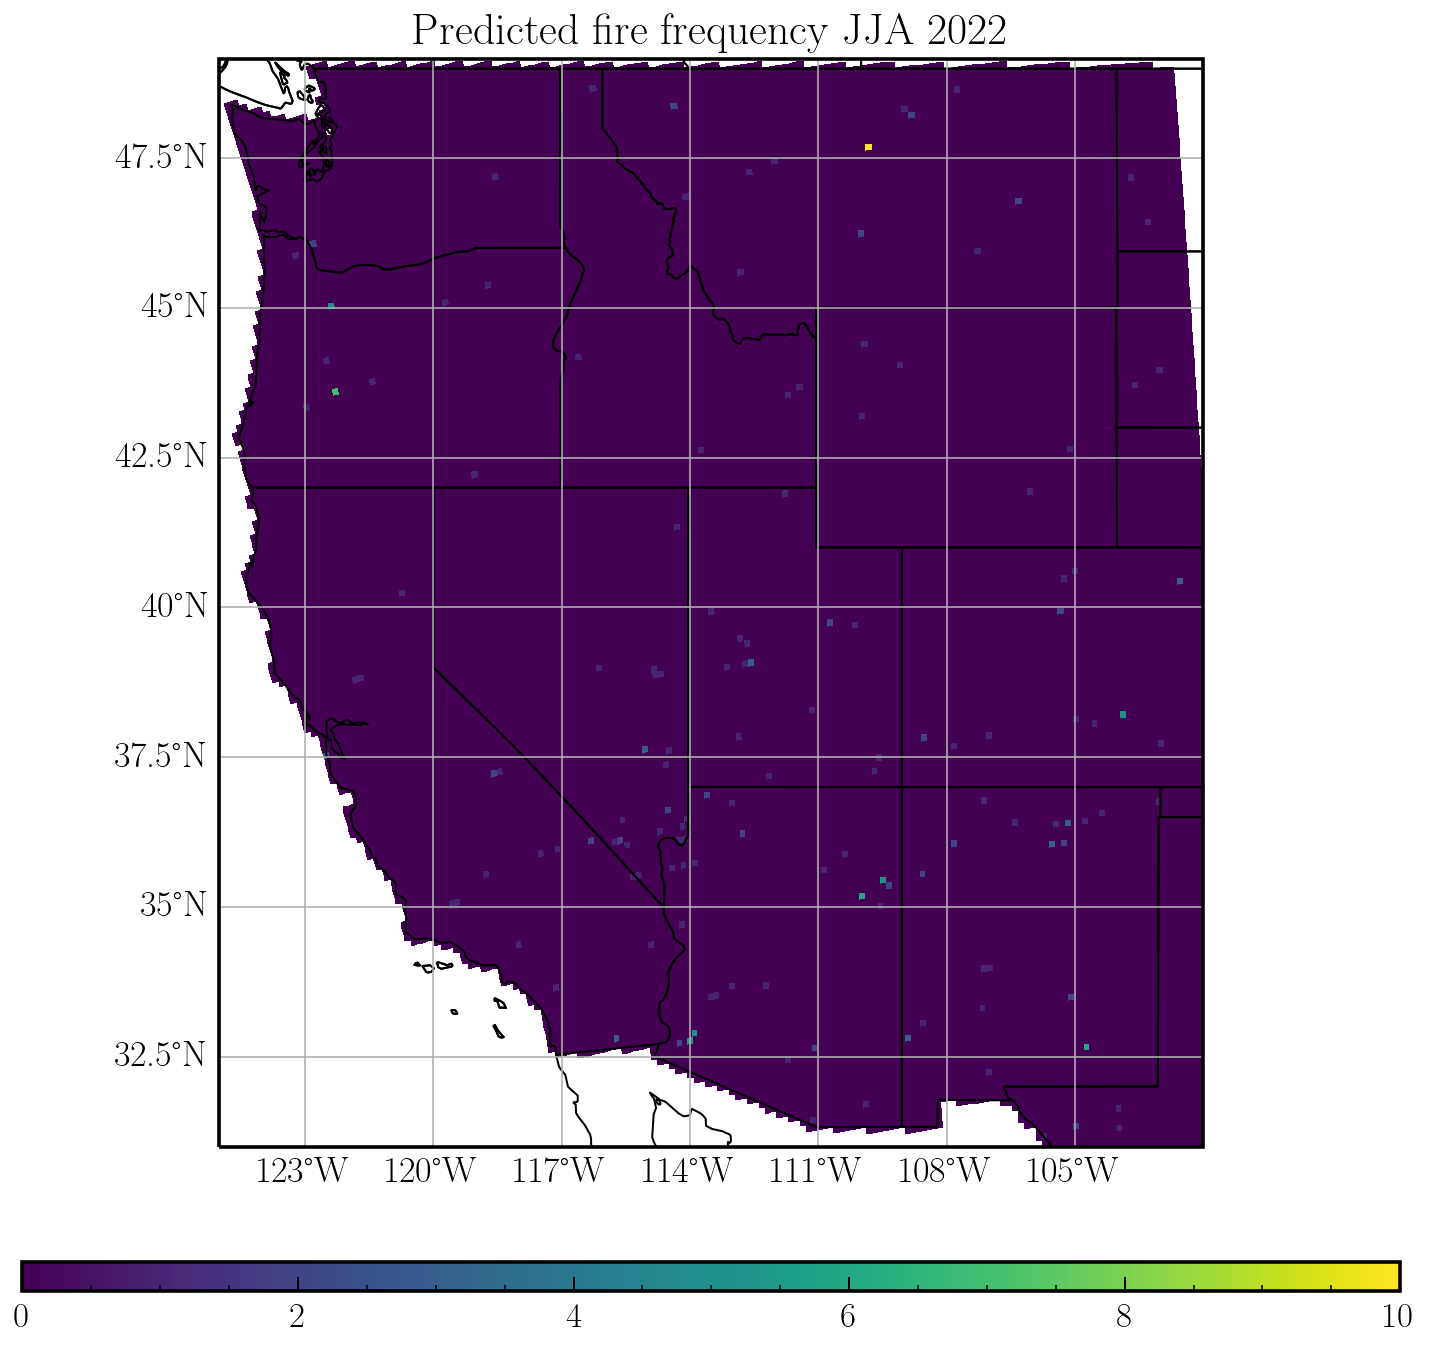

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], pred_freq_xarr.sum(axis= 0, skipna= False), cmap=plt.cm.viridis) 
cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Predicted fire frequency JJA 2022', fontsize= 22);

### Fire probability map

In [ ]:
param_vec= []
for m in pred_mon_arr:
    X_arr= np.array(X_pred_test_df.groupby('month').get_group(m).drop(columns= ['reg_indx', 'month']), dtype= np.float32)
    param_vec.append(mdn_zipd.predict(x= tf.constant(X_arr)))
param_vec= np.array(param_vec).reshape(3*23903, 3)

747/747 [==============================] - 0s 301us/step


In [ ]:
X_pred_ur_df['pred_fire_prob']= np.zeros_like(X_pred_ur_df['fire_freq'], dtype= np.float32)
X_pred_ur_df.loc[~X_pred_ur_df['Tmax'].isna(), 'pred_fire_prob']= param_vec[:, 1]
X_pred_ur_df.loc[X_pred_ur_df['Tmax'].isna(), 'pred_fire_prob']= np.nan

In [ ]:
pred_prob_xarr= xarray.DataArray(data= X_pred_ur_df['pred_fire_prob'].to_numpy().reshape(3, 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], np.linspace(0, 2, 3, dtype= np.int64)),),)

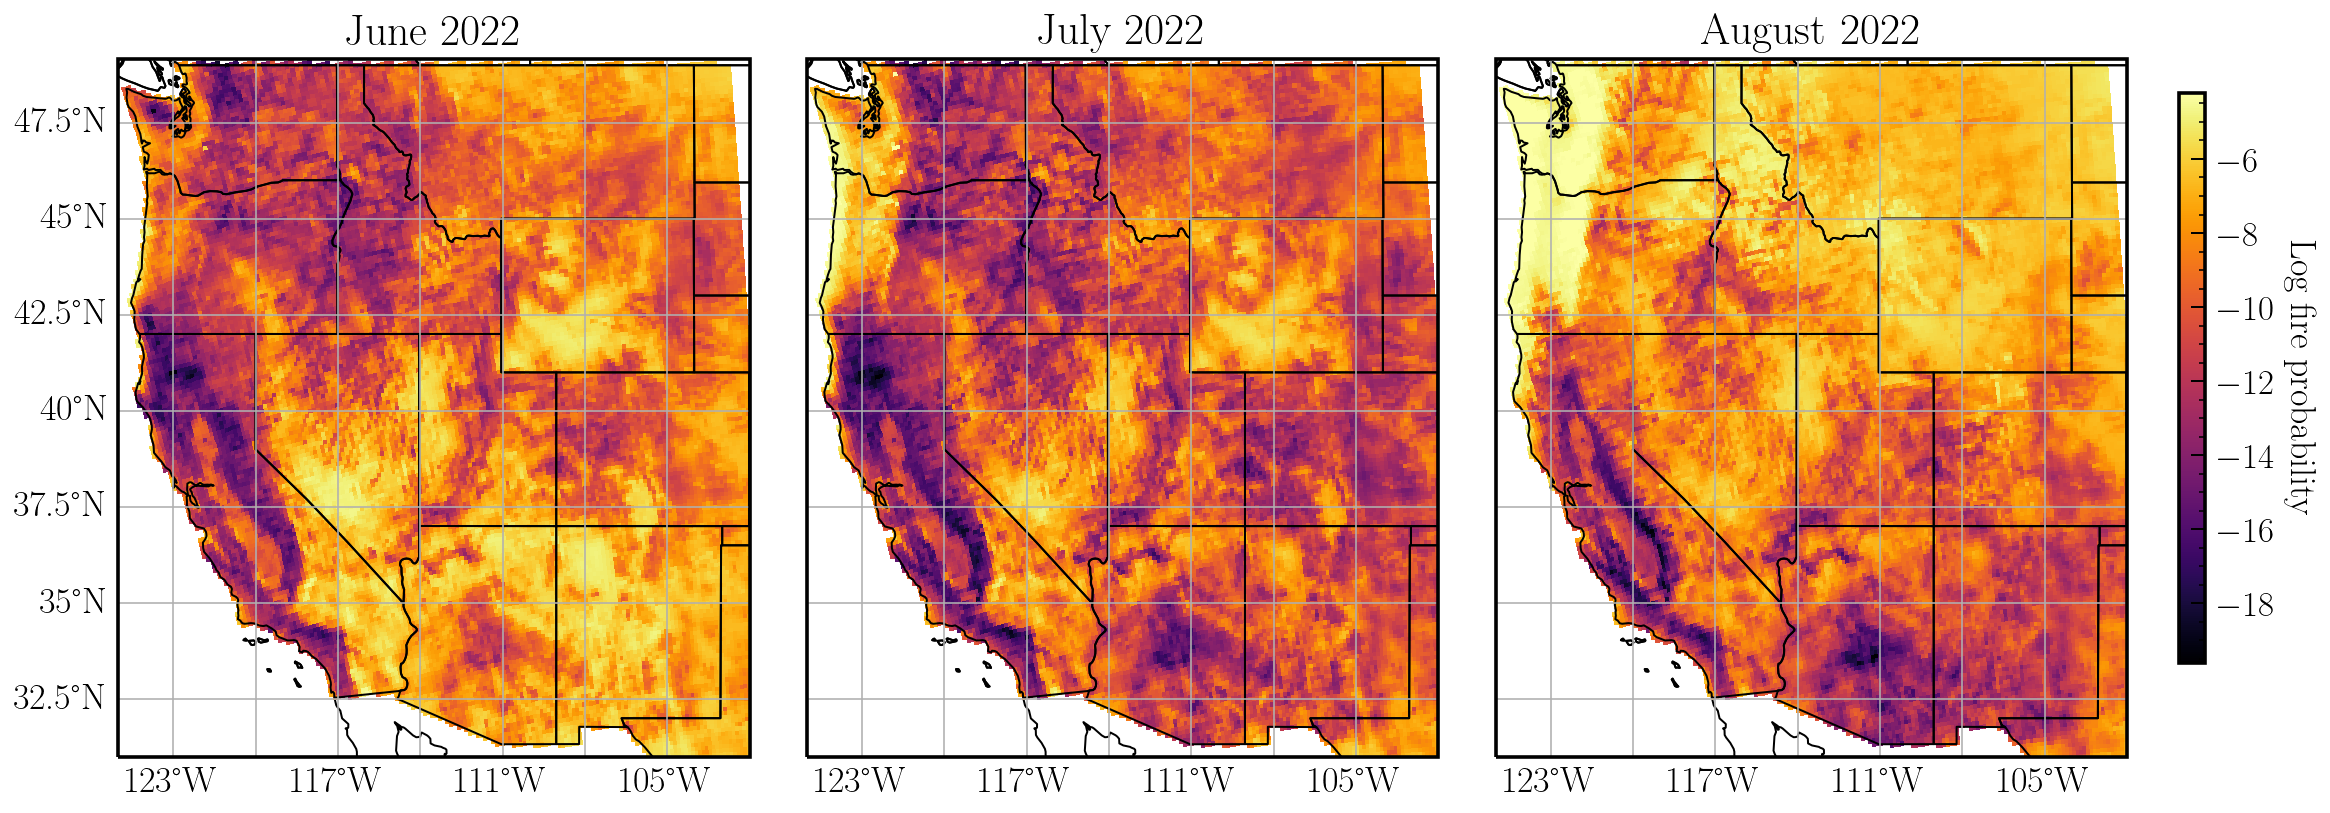

In [ ]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.log10(pred_prob_xarr[2, : , :]), cmap=plt.cm.inferno) #.mean(axis= 0, skipna= False)
#cax= fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.1, ax.get_position().width, 0.02])
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'June 2022', fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.log10(pred_prob_xarr[1, : , :]), cmap=plt.cm.inferno) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'July 2022', fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.log10(pred_prob_xarr[0, : , :]), cmap=plt.cm.inferno) #.mean(axis= 0, skipna= False)
cax= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.05])
cbar= fig.colorbar(CS2, cax= cax, orientation= 'vertical')
cbar.set_label(r'Log fire probability', labelpad= 20, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'August 2022', fontsize= 22);
#plt.savefig('../plots/smlfire_output/pred_fire_prob_2022.png', bbox_inches='tight', dpi= 200);